In [161]:
import numpy as np
from numpy.linalg import norm
import scipy.io
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [172]:
ex4data = scipy.io.loadmat("./ex4data1.mat")
initX = ex4data['X']
y = ex4data['y'][:,0]
#y[y==10] = 0
m, n = initX.shape
m, n
X = np.hstack((np.ones((m,1)), initX))
weights = scipy.io.loadmat('./ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
input_layer_size = Theta1.shape[1] - 1
hidden_layer_size = Theta2.shape[1] - 1
num_labels = Theta2.shape[0]

In [173]:
import matplotlib.image as mpimg

def displayData(X):
    fig, axis = plt.subplots(10,10,figsize=(8,8))
    for i in range(10):
        for j in range(10):
            axis[i,j].imshow(X[i*10+j,:].reshape(20,20,order="F"), cmap="hot")
            axis[i,j].axis("off")

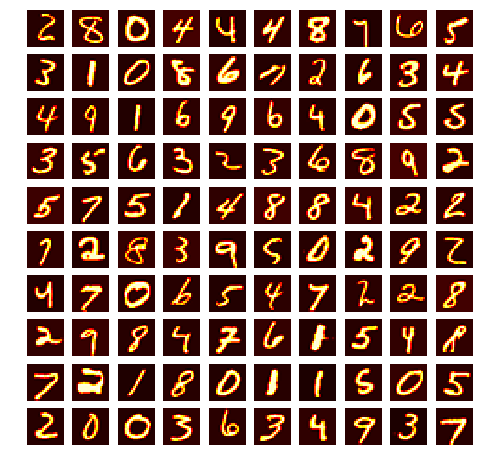

In [174]:
# Randomly select 100 data points to display
randIndices = np.random.permutation(m)
sel = initX[randIndices[:100],:]

displayData(sel)

In [204]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def rand_initialize_weights(L_in, L_out):
    eps = 0.12
    return np.random.uniform(-eps, eps, (L_out, 1 + L_in))

def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_):
    
    boundary = (input_layer_size + 1) * hidden_layer_size
    
    Theta1 = nn_params[:boundary].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[boundary:].reshape((num_labels, hidden_layer_size + 1))
    
    Theta1_grad = np.zeros_like(Theta1)
    Theta2_grad = np.zeros_like(Theta2)
    
    m = X.shape[0]
    
    y = y.reshape((len(y), 1))

    yMatrix = 1 * (np.arange(1, num_labels + 1) == y)
    
    a1 = X
    z2 = a1.dot(Theta1.T)
    
    a2 = np.hstack((np.ones((z2.shape[0], 1)), sigmoid(z2)))
    z3 = a2.dot(Theta2.T)

    a3 = h = sigmoid(z3)

    #cost function
    J = -np.sum(yMatrix * np.log(h) + (1.0 - yMatrix) * np.log(1.0 - h)) / m
    
    # regularization
    reg = lambda_ / (2 * m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))

    # backprop
    d3 = h - yMatrix
    d2 = np.dot(Theta2[:,1:].T, d3.T) * sigmoid_gradient(z2).T
    
    Delta1 = np.dot(d2, a1)
    Delta2 = np.dot(d3.T, a2)
    
    Theta1_reg = lambda_ / m * Theta1
    Theta2_reg = lambda_ / m * Theta2
    Theta1_reg[:,0] = 0
    Theta2_reg[:,0] = 0
    
    Theta1_grad = 1 / m * Delta1 + Theta1_reg
    Theta2_grad = 1 / m * Delta2 + Theta2_reg
    
    gradient = np.concatenate((Theta1_grad.flatten('C'), Theta2_grad.flatten('C')))    
    
    return J + reg, gradient

In [206]:
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))

# feed-forward
cost, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 0)
print('Cost at parameters (loaded from ex4weights) without regularization: %f' % cost)
print('(this value should be about 0.287629)')

# feed-forward with regularization
cost, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)
print('Cost at parameters (loaded from ex4weights) with regularization: %f' % cost)
print('(this value should be about 0.383770)')

Cost at parameters (loaded from ex4weights) without regularization: 0.287629
(this value should be about 0.287629)
Cost at parameters (loaded from ex4weights) with regularization: 0.383770
(this value should be about 0.383770)


In [123]:
initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size);
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels);

print(initial_Theta1.shape)
print(initial_Theta2.shape)

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()))

(25, 401)
(10, 26)


In [148]:
def compute_numerical_gradient(cost_func, theta):
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    eps = 1e-4
    for p in range(theta.size):
        perturb[p] = eps
        loss1, _ = cost_func(theta - perturb)
        loss2, _ = cost_func(theta + perturb)
        numgrad[p] = (loss2 - loss1) / (2.0 * eps)
        perturb[p] = 0.0
    return numgrad

def debug_initialize_weights(fan_out, fan_in):
    return np.sin(1 + np.arange((1 + fan_in) * fan_out)).reshape((1 + fan_in, fan_out)).T / 10.0

def check_nn_gradients(lambda_ = 0.0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # We generate some 'random' test data
    Theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    Theta2 = debug_initialize_weights(num_labels, hidden_layer_size)
    
    # Reusing debugInitializeWeights to generate X
    X = debug_initialize_weights(m, input_layer_size - 1)
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    y = 1 + np.arange(1, m + 1) % num_labels
    
    # unroll parameters
    nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))
    
    # declare anonymous function
    cost_func = lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
    
    cost, grad = cost_func(nn_params)
    
    num_grad = compute_numerical_gradient(cost_func, nn_params)
    
    print(np.vstack((grad, num_grad)).T)
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)')
    diff = norm(num_grad - grad) / norm(num_grad + grad)
    print('If your backpropagation implementation is correct, then')
    print('the relative difference will be small (less than 1e-9).')
    print('Relative Difference: %g' % diff)

In [165]:
lambda_ = 3.0
check_nn_gradients(lambda_)

[[-9.27825236e-03 -9.27825235e-03]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911960e-03  8.89911959e-03]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010762e-03 -8.36010761e-03]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813551e-03  7.62813550e-03]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798370e-03 -6.74798370e-03]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101547e-02  5.46101548e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928696e-05  3.81928711e-05]
 [ 1.17148233e-01  1

In [168]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    h1 = sigmoid(X.dot(Theta1.T))
    h2 = sigmoid(np.concatenate((np.ones((m, 1)), h1), axis=1).dot(Theta2.T))
    return 1 + np.argmax(h2, axis=1)

In [169]:
print('Training Neural Network...')
result = optimize.minimize(
    nn_cost_function,
    initial_nn_params,
    args=(input_layer_size, hidden_layer_size, num_labels, X, y, lambda_),
    method='CG',
    jac=True,
    options={
        'maxiter': 50,
        'disp': False,
    }
)
nn_params = result.x
boundary = (input_layer_size + 1) * hidden_layer_size
Theta1 = nn_params[:boundary].reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = nn_params[boundary:].reshape((num_labels, hidden_layer_size + 1))
predictions = predict(Theta1, Theta2, X)
accuracy = 100 * np.mean(predictions == y)
print('Training set accuracy: %0.2f %%' % accuracy)

Training Neural Network...
Training set accuracy: 95.86 %
